<a href="https://colab.research.google.com/github/satishchaudhary382/RFM/blob/master/Web_scraping_Rough_Try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [861]:
# !pip install selenium
# !apt-get update 
# !apt install chromium-chromedriver
import time
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings("ignore")

from selenium import webdriver

In [862]:
#loading necessary driver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
driver =webdriver.Chrome('chromedriver',chrome_options=chrome_options)


In [863]:
#Loading the page to be scraped
url = "https://www.nepalipaisa.com/CompanyDetail.aspx?quote=gufl"
driver.get(url)
driver.find_elements_by_xpath("//li[@title='pricehistory']//a[1]")[0].click()
datefield = driver.find_elements_by_xpath("//input[@class='sfInputbox hasDatepicker']")
datefield[0].click()
datefield[0].clear()
datefield[0].send_keys("2019-10-17")
search_btn = driver.find_element_by_xpath("(//input[@class='sfBtn sfPrimaryBtn'])[2]")
search_btn.click()


In [864]:
# Extracting Heading 
heading = []
for i in range(1,12):
  h = driver.find_elements_by_xpath(f'//*[@id="tblFloorList"]/thead/tr/th[{i}]')
  for j in h:
    heading.append(j.text)

#Identifying number of data 
w = []
b = driver.find_elements_by_xpath(f'//*[@id="tblFloorList"]/tbody')
for a in b:
  w.append(a.text)

c = []
for i in w:
  c.append(i.split("\n"))
print(f"The number of data available is {c[-1][-1].split()[0]}")
  

The number of data available is 174


In [865]:
# Extracting data
body = []
for i in range(0,pd.to_numeric(c[-1][-1].split()[0])):
  b = driver.find_elements_by_xpath(f'//*[@id="tblFloorList"]/tbody/tr[{i}]')
  for a in b:
    body.append(a.text)

In [866]:
driver.quit()

In [867]:
data = []
for i in body:
  data.append(i.split())

#Creating dataFrame
df = pd.DataFrame(data, columns = heading)
df

,S.N.,Date,No of Transactions,Max Price,Min Price,Closing Price,Traded Shares,Total Amount,Prev. Closing,Difference Rs.,% Change
0,1,2020-10-14,47,157,147,147,9901.00,1471724.00,150,-3,-2
1,2,2020-10-13,40,159,145,150,7518.00,1124784.00,152,-2,-1.32
2,3,2020-10-12,94,165,151,152,37555.00,5825556.00,159,-7,-4.4
3,4,2020-10-11,47,164,156,159,9749.00,1558722.00,165,-6,-3.64
4,5,2020-10-10,160,174,159,165,33788.00,5573437.00,163,2,1.23
...,...,...,...,...,...,...,...,...,...,...,...
168,169,2019-11-02,1,115,115,115,20.00,2300.00,113,2,1.77
169,170,2019-10-23,8,115,111,113,630.00,71810.00,109,4,3.67
170,171,2019-10-21,5,110,109,109,2055.00,224095.00,109,0,0
171,172,2019-10-20,3,109,109,109,150.00,16350.00,110,-1,-0.91


In [868]:

# Converting datas into appropriate datatypes
df[['S.N.', 'No of Transactions', 'Max Price', 'Min Price', 'Closing Price', 'Traded Shares', 'Total Amount', 'Prev. Closing', 'Difference Rs.', '% Change']] = df[['S.N.',  'No of Transactions', 'Max Price', 'Min Price', 'Closing Price', 'Traded Shares', 'Total Amount', 'Prev. Closing', 'Difference Rs.', '% Change']].apply(pd.to_numeric)
df['Date'] = df['Date'].apply(pd.to_datetime)
df.set_index("Date", inplace= True)

In [869]:
df[['Closing Price','Min Price', 'Closing Price']].replace(to_replace=0, method='bfill', inplace = True)

Closing Price    None
Min Price        None
Closing Price    None
dtype: object

In [870]:
df.sort_values(by = "Date", ascending = True, inplace = True)

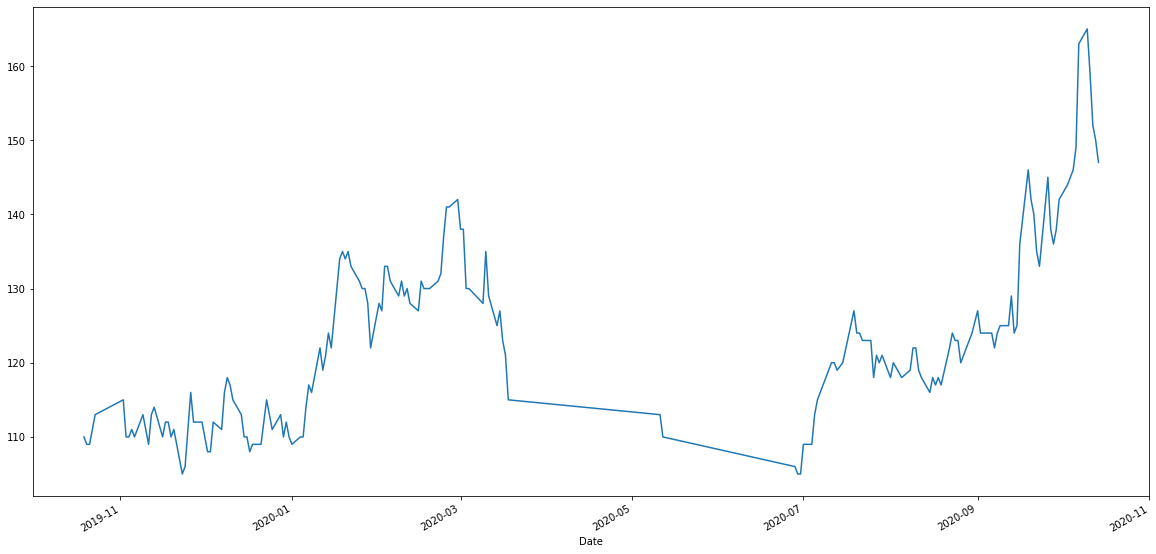

In [871]:
df['Closing Price'].plot(figsize = (20,10))

In [872]:
# !pip install pandas_ta
# !pip install MarketProfile
import pandas_ta as ta
from market_profile import MarketProfile

In [873]:
import matplotlib.pyplot as plt
# df = df[500:600]
a  = ta.hma(df['Closing Price'],30)
b = ta.hma(df['Closing Price'].shift(-2),30)

In [874]:
# df.reset_index(inplace = True)

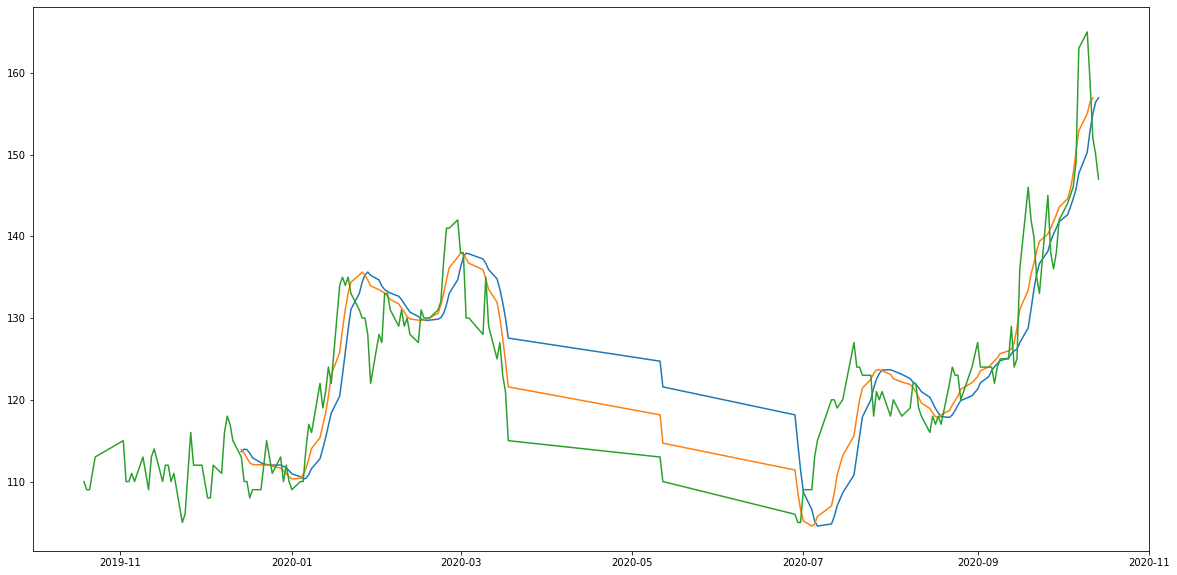

In [875]:
plt.figure(figsize = (20,10))
plt.plot(a)
plt.plot(b)
plt.plot(df['Closing Price'])
# plt.hlines(p, df.index.min(), df.index.max(),color = "red")
# plt.hlines(v[0], df.index.min(), df.index.max())
# plt.hlines(v[1], df.index.min(), df.index.max())

In [876]:
raw = df.copy()

In [877]:
raw.columns

Index(['S.N.', 'No of Transactions', 'Max Price', 'Min Price', 'Closing Price',
       'Traded Shares', 'Total Amount', 'Prev. Closing', 'Difference Rs.',
       '% Change'],
      dtype='object')

In [878]:
file = raw[['Max Price', 'Min Price', 'Closing Price','Traded Shares']]
file.rename(columns = {"Max Price":"High",
                       "Min Price":"Low",
                       "Closing Price":"Close",
                       "Traded Shares":"Volume"}, inplace = True)

In [879]:
f = file.iloc[:]

In [880]:
mp = MarketProfile(f)
mp_slice = mp[f.index.min():f.index.max()]

In [881]:
p = mp_slice.poc_price
v = mp_slice.value_area



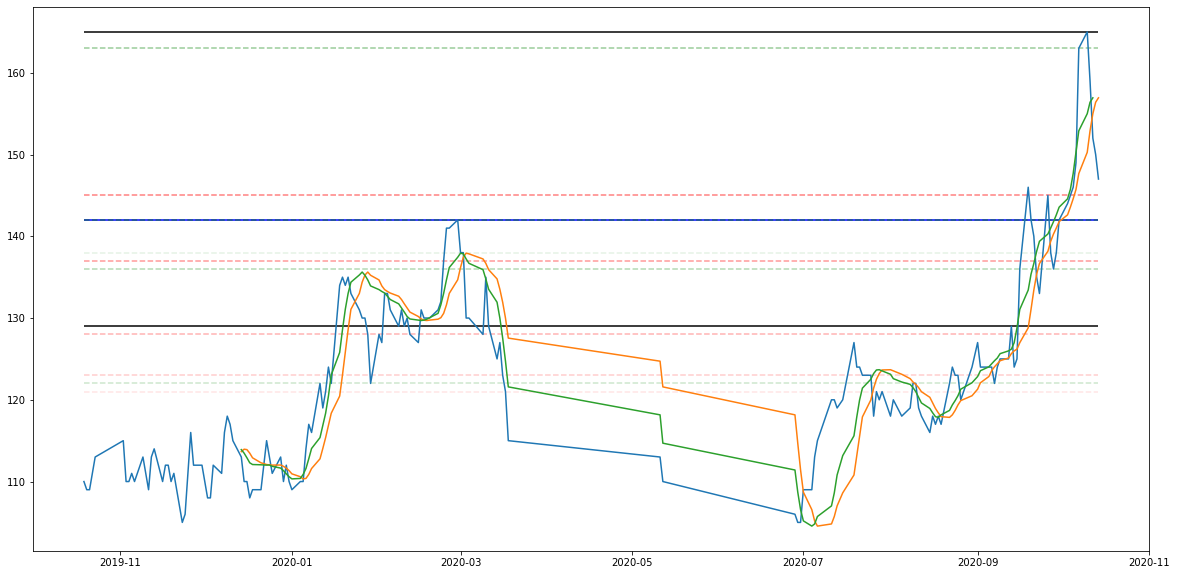

In [882]:
plt.figure(figsize = (20,10))
plt.plot(f.Close)
plt.hlines(p, f.index.min(), f.index.max(),color = "blue")
plt.hlines(v[0], f.index.min(), f.index.max())
plt.hlines(v[1], f.index.min(), f.index.max())
plt.plot(ta.hma(f['Close'],30))
plt.plot(ta.hma(f['Close'].shift(-2),30))
#high Volume Nodes
plt.hlines(mp_slice.high_value_nodes.sort_values().index[-1], f.index.min(), f.index.max(), color = "green", alpha =0.5, linestyle = "--")
plt.hlines(mp_slice.high_value_nodes.sort_values().index[-2], f.index.min(), f.index.max(), color = "green", alpha =0.4, linestyle = "--")
plt.hlines(mp_slice.high_value_nodes.sort_values().index[-3], f.index.min(), f.index.max(), color = "green", alpha =0.3, linestyle = "--")
plt.hlines(mp_slice.high_value_nodes.sort_values().index[-4], f.index.min(), f.index.max(), color = "green", alpha =0.2, linestyle = "--")
plt.hlines(mp_slice.high_value_nodes.sort_values().index[-5], f.index.min(), f.index.max(), color = "green", alpha =0.1, linestyle = "--")

#Low Volume Nodes
plt.hlines(mp_slice.low_value_nodes.sort_values().index[-1], f.index.min(), f.index.max(), color = "red", alpha =0.5, linestyle = "--")
plt.hlines(mp_slice.low_value_nodes.sort_values().index[-2], f.index.min(), f.index.max(), color = "red", alpha =0.4, linestyle = "--")
plt.hlines(mp_slice.low_value_nodes.sort_values().index[-3], f.index.min(), f.index.max(), color = "red", alpha =0.3, linestyle = "--")
plt.hlines(mp_slice.low_value_nodes.sort_values().index[-4], f.index.min(), f.index.max(), color = "red", alpha =0.2, linestyle = "--")
plt.hlines(mp_slice.low_value_nodes.sort_values().index[-5], f.index.min(), f.index.max(), color = "red", alpha =0.1, linestyle = "--")